## Load Trained SVM Model

In [ ]:
import joblib

# 1. Define the path to the saved model file
save_path = "/content/svm_model.joblib"

# 2. Use joblib.load() to load the model and scaler
#    Store the loaded dictionary in a variable
loaded_objects = joblib.load(save_path)

# 3. Extract the SVM model
svm_model = loaded_objects['model']

# 4. Extract the StandardScaler
scaler = loaded_objects['scaler']

print(f"SVM model and StandardScaler loaded successfully from {save_path}")

SVM model and StandardScaler loaded successfully from /content/svm_model.joblib


# Function Helper Prediction Demo

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog # Ensure hog is imported for extract_hog

# --- Re-define all necessary helper functions and global objects ---
# This ensures the function is self-contained for execution if previous cells are not run sequentially

# Assuming scaler and svm_model are globally available from previous steps
# If they are not, you would need to load them here again:
# import joblib
# loaded_objects = joblib.load("/content/svm_model.joblib")
# svm_model = loaded_objects['model']
# scaler = loaded_objects['scaler']

# From Cell 6
def resize_and_center(img, size=28):
    if img is None or img.size == 0:
        return np.zeros((size, size), dtype=np.uint8)
    h, w = img.shape[:2]
    if h < 1 or w < 1:
        return np.zeros((size, size), dtype=np.uint8)
    scale = size / max(h, w)
    new_h = max(1, int(h * scale))
    new_w = max(1, int(w * scale))
    resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
    canvas = np.zeros((size, size), dtype=np.uint8)
    ch = (size - new_h) // 2
    cw = (size - new_w) // 2
    canvas[ch:ch+new_h, cw:cw+new_w] = resized
    return canvas

def robust_preprocessing(image):
    """
    Performs noise reduction and conditionally applies contrast enhancement,
    returning an optimally cleaned grayscale image and its standard deviation.
    """
    # 1. Convert to Grayscale (if BGR/RGB input)
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    # 2. Apply a light GaussianBlur as baseline denoising
    blurred = cv2.GaussianBlur(gray, (3, 3), 0)

    # 3. Analyze the processed grayscale image: calculate standard deviation of pixel intensities
    std_dev = np.std(blurred) # Calculate standard deviation of pixel intensities

    # 4. Conditionally apply CLAHE for contrast enhancement
    if std_dev < 40: # Threshold for low contrast
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        enhanced = clahe.apply(blurred)
        # Further denoising after enhancement if needed for very noisy low-contrast images
        cleaned_grayscale = cv2.GaussianBlur(enhanced, (3, 3), 0)
        applied_clahe = True
    else:
        # For images with good contrast, return the baseline denoised image
        cleaned_grayscale = blurred
        applied_clahe = False

    return cleaned_grayscale, std_dev

def extract_hog(img28, pixels_per_cell=(4, 4), cells_per_block=(2,2), orientations=9,
                transform_sqrt=True, block_norm='L2-Hys', visualize=False):
    if img28 is None:
        raise ValueError("extract_hog received None image")
    img = np.array(img28)
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if img.shape != (28, 28):
        img = cv2.resize(img, (28,28), interpolation=cv2.INTER_AREA)
    if img.dtype != np.uint8:
        img = (255 * (img.astype(np.float32) - img.min()) / max(1e-6, (img.max() - img.min()))).astype(np.uint8)
    if visualize:
        features, hog_image = hog(img,
                                  orientations=orientations,
                                  pixels_per_cell=pixels_per_cell,
                                  cells_per_block=cells_per_block,
                                  transform_sqrt=transform_sqrt,
                                  block_norm=block_norm,
                                  visualize=True,
                                  feature_vector=True)
        return features, hog_image
    else:
        features = hog(img,
                       orientations=orientations,
                       pixels_per_cell=pixels_per_cell,
                       cells_per_block=cells_per_block,
                       transform_sqrt=transform_sqrt,
                       block_norm=block_norm,
                       visualize=False,
                       feature_vector=True)
        return features

# --- Segmentation Helpers (ensure they use binarized image for thresholding or accept grayscale and binarize) ---
def _gaussian_kernel1d(kernlen=11, sigma=2):
    if kernlen % 2 == 0:
        kernlen += 1
    half = kernlen // 2
    x = np.arange(-half, half+1)
    g = np.exp(-(x**2)/(2*sigma*sigma))
    return g / g.sum()

def _find_contiguous_true_regions(boolean_array):
    if boolean_array.size == 0: return []
    diff = np.diff(boolean_array.astype(np.int8))
    starts = np.where(diff == 1)[0] + 1
    ends = np.where(diff == -1)[0] + 1
    if boolean_array[0]:
        starts = np.r_[0, starts]
    if boolean_array[-1]:
        ends = np.r_[ends, boolean_array.size]
    return list(zip(starts, ends))

def split_big_regions(regions, width, n_expected, min_width=5):
    if not regions:
        return []
    regions_sorted = sorted(regions, key=lambda r: r[1] - r[0], reverse=True)
    output = list(regions)
    deficit = n_expected - len(output)
    if deficit <= 0:
        return output
    new_regions = []
    for (s, e) in regions_sorted:
        w = e - s
        if w < min_width:
            continue
        if deficit <= 0:
            new_regions.append((s, e))
            continue
        possible_splits = max(1, w // max(min_width, 1)) # min_region_width was not defined here, using min_width
        splits = min(deficit + 1, possible_splits)
        if splits <= 1:
            new_regions.append((s, e))
            continue
        step = max(1, w // splits)
        cur = s
        for i in range(splits):
            x1 = cur
            x2 = e if i == splits - 1 else cur + step
            if x2 - x1 >= 2:
                new_regions.append((x1, x2))
            cur += step
        deficit -= (splits - 1)
    if len(new_regions) < n_expected:
        step = max(1, width // n_expected)
        new_regions = []
        for i in range(n_expected):
            x1 = i * step
            x2 = width if i == n_expected - 1 else (i + 1) * step
            if x2 - x1 >= 2:
                new_regions.append((x1, x2))
    return sorted(new_regions, key=lambda r: r[0])

# --- MODIFIED fallback_projection_split to accept grayscale and binarize internally ---
def fallback_projection_split(img_gray, n_expected, debug=False):
    """
    Projection-only segmentation fallback with patches for zero-width fixes.
    Now accepts grayscale and performs binarization internally.
    """
    h, w = img_gray.shape

    # Standardize polarity: ensure digits are dark on light background initially
    # This makes subsequent THRESH_BINARY_INV consistently produce white digits on black background
    if np.mean(img_gray) < 127: # If image is predominantly dark (light digits on dark bg)
        img_gray = cv2.bitwise_not(img_gray) # Invert to dark digits on light bg

    # Internal binarization (now consistently applied to dark digits on light background)
    _, th = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    proj = np.sum(th, axis=0)
    kernel = _gaussian_kernel1d(21, 4)
    proj_s = np.convolve(proj, kernel, mode='same')
    thr = proj_s.max() * 0.12
    mask = proj_s > thr
    regions = _find_contiguous_true_regions(mask)

    if n_expected is not None and len(regions) < n_expected:
        regions = split_big_regions(regions, w, n_expected)

    # FINAL uniform forced split
    if n_expected is not None and len(regions) != n_expected:
        step = max(1, w // n_expected)
        regions = []
        for i in range(n_expected):
            s = i * step
            e = w if i == n_expected - 1 else (i + 1) * step
            if e - s >= 2:
                regions.append((s, e))

    # Crop
    crops = []
    for (s, e) in regions:
        if e - s < 2:
            continue
        digit = th[:, s:e]
        crop28 = resize_and_center(digit, size=28)
        crops.append({"bbox": (s,0,e-s,h), "crop": crop28})

    if debug:
        print("[Fallback] Projection split used (patched).")

    return crops, th

def projection_split_region(roi, x0, y0, target_size):
    """
    Projection-based split inside one contour.
    Patch #2 & #3: skip thin/zero regions
    """
    proj = np.sum(roi, axis=0)
    peaks = proj > proj.max()*0.25
    regs = _find_contiguous_true_regions(peaks)

    crops = []
    for (s,e) in regs:
        if e - s < 2:
            continue
        d = roi[:, s:e]
        d28 = resize_and_center(d, size=target_size)
        crops.append({
            "bbox": (x0 + s, y0, e-s, roi.shape[0]),
            "crop": d28
        })
    return crops

# --- MODIFIED segment_digits_primer_hybrid with adaptive binarization and morphology ---
def segment_digits_primer_hybrid(
    img_gray,
    std_dev, # New input parameter
    n_expected=None,
    debug=False,
    min_area=60,
    target_size=28
):
    """
    Hybrid segmentation pipeline for PRIMER dataset.
    Now adaptively binarizes and applies morphological operations based on image std_dev.
    """

    # Standardize polarity: ensure digits are dark on light background initially
    # This makes subsequent THRESH_BINARY_INV consistently produce white digits on black background
    if np.mean(img_gray) < 127: # If image is predominantly dark (light digits on dark bg)
        img_gray_normalized = cv2.bitwise_not(img_gray) # Invert to dark digits on light bg
        polarity_normalized_message = " (Inverted for dark-on-light)"
    else:
        img_gray_normalized = img_gray.copy() # Already dark-on-light or neutral
        polarity_normalized_message = " (Polarity maintained)"

    std_dev_segmentation_threshold = 50 # Threshold to distinguish clean from complex images
    binarization_path = ""

    # Conditional binarization and morphological operations
    if std_dev > std_dev_segmentation_threshold: # Clean, high-contrast image
        # Simpler binarization with Otsu thresholding
        _, th = cv2.threshold(img_gray_normalized, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

        # REMOVED morphological operations for clean images
        th2 = th # Direct use of binarized image without morphology

        binarization_path = "Clean Image Path (Otsu, NO Morphology)"
    else: # Complex, lower-contrast image
        # Existing adaptive thresholding
        blur = cv2.GaussianBlur(img_gray_normalized, (3,3), 0)
        th = cv2.adaptiveThreshold(
            blur, 255,
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY_INV, # Invert so digits are white on black
            15, 5
        )
        # Existing tuned morphological operations (Opening and Erosion)
        kernel_morph = np.ones((2,2),np.uint8)
        th_separated = cv2.morphologyEx(th, cv2.MORPH_OPEN, kernel_morph, iterations=1)
        th2 = cv2.erode(th_separated, kernel_morph, iterations=1)
        binarization_path = "Complex Image Path (Adaptive + 2x2 Open/Erode)"

    # --- Contours ---
    contours, _ = cv2.findContours(th2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    raw_boxes = []
    for c in contours:
        x,y,w,h = cv2.boundingRect(c)
        if w*h >= min_area:
            raw_boxes.append((x,y,w,h))

    # Sort L→R
    raw_boxes = sorted(raw_boxes, key=lambda b: b[0])

    # ======================================================
    # CASE 1: Contours fail → fallback
    # ======================================================
    if len(raw_boxes) == 0 or (n_expected is not None and len(raw_boxes) != n_expected):
        # Pass the original img_gray to fallback_projection_split for binarization there
        return fallback_projection_split(img_gray, n_expected, debug) # Use original img_gray for fallback

    # ======================================================
    # CASE 2: REFINE EACH CONTOUR
    # ======================================================
    final_crops = []

    for (x,y,w,h) in raw_boxes:
        if w < 2 or h < 2:
            continue

        # Use th2 for ROI as it's the result of refined morphology
        roi = th2[y:y+h, x:x+w]
        proj = np.sum(roi, axis=0)
        split_cols = np.where(proj == 0)[0]

        # CASE: no blank column → maybe merged digits
        if len(split_cols) == 0 and n_expected and len(raw_boxes) < n_expected:
            sub_crops = projection_split_region(roi, x, y, target_size)
            final_crops.extend(sub_crops)
        else:
            # Single digit
            digit28 = resize_and_center(roi, size=target_size)
            final_crops.append({
                "bbox": (x,y,w,h),
                "crop": digit28
            })

    # ------------------------------------------------------
    # If mismatch → fallback
    # ------------------------------------------------------
    if n_expected is not None and len(final_crops) != n_expected:
        # Pass the original img_gray to fallback_projection_split for binarization there
        return fallback_projection_split(img_gray, n_expected, debug) # Use original img_gray for fallback

    # Sort left→right
    final_crops = sorted(final_crops, key=lambda c: c["bbox"][0])

    if debug:
        print(f"Debug visualization in segment_digits_primer_hybrid is active. Polarity: {polarity_normalized_message}, Path chosen: {binarization_path}")
        import matplotlib.pyplot as plt
        img_box = cv2.cvtColor(th2, cv2.COLOR_GRAY2BGR) # Draw on the binary image
        for c in final_crops:
            (x,y,w,h)=c["bbox"]
            cv2.rectangle(img_box,(x,y),(x+w,y+h),(0,255,0),2)
        plt.figure(figsize=(12,4))
        plt.imshow(img_box)
        plt.title(f"Hybrid PRIMER segmentation ({len(final_crops)} digits) on binarized image")
        plt.show()

        if final_crops:
            fig, axes = plt.subplots(1, len(final_crops), figsize=(len(final_crops)*2, 2))
            if len(final_crops) == 1:
                axes = [axes]
            for i, crop_dict in enumerate(final_crops):
                axes[i].imshow(crop_dict['crop'], cmap='gray')
                axes[i].set_title(f'Segment {i+1}')
                axes[i].axis('off')
            plt.suptitle('Segmented Digit Crops (28x28) from segment_digits_primer_hybrid')
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.show()


    return final_crops, th2

def predict_multidigit_from_image(image_path_or_array, hog_params=None, debug=False):
    """
    Performs robust multi-digit prediction from a raw input image.

    Args:
        image_path_or_array (str or np.ndarray): Path to the image file or a NumPy array representing the image.
        hog_params (dict, optional): Dictionary of HOG parameters. Defaults to parameters used during training.
        debug (bool, optional): If True, displays intermediate steps and visualizations.

    Returns:
        tuple: (predicted_number_str, segmented_crops) where
               predicted_number_str (str): The predicted multi-digit number as a string.
               segmented_crops (list): A list of dictionaries, each containing 'crop' (28x28 image) and 'predicted_label'.
               Returns ('', []) if no digits are found or processed.
    """

    if hog_params is None:
        # Default HOG parameters used during training
        hog_params = {
            'pixels_per_cell': (4, 4),
            'cells_per_block': (2, 2),
            'orientations': 9,
            'transform_sqrt': True,
            'block_norm': 'L2-Hys'
        }

    # 1. Load image if path is provided
    if isinstance(image_path_or_array, str):
        raw_image = cv2.imread(image_path_or_array)
        if raw_image is None:
            print(f"Error: Could not load image from {image_path_or_array}")
            return "", []
    else:
        raw_image = image_path_or_array.copy() # Use a copy to avoid modifying original

    if raw_image.ndim == 3 and raw_image.shape[2] == 4: # Handle RGBA images if any
        raw_image = cv2.cvtColor(raw_image, cv2.COLOR_RGBA2RGB)

    if debug:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB) if len(raw_image.shape) == 3 else raw_image, cmap='gray' if len(raw_image.shape) == 2 else None)
        plt.title('Original Image')
        plt.axis('off')

    # 2. Apply robust preprocessing (now returns grayscale and std_dev)
    cleaned_grayscale_image, std_dev = robust_preprocessing(raw_image)

    if debug:
        plt.subplot(1, 2, 2)
        plt.imshow(cleaned_grayscale_image, cmap='gray')
        preprocessing_title = f'Robust Preprocessed Grayscale Image (StdDev: {std_dev:.2f})'
        # Determine if CLAHE was applied based on std_dev threshold (consistent with robust_preprocessing logic)
        if std_dev < 40:
            preprocessing_title += ' (CLAHE applied)'
        else:
            preprocessing_title += ' (CLAHE skipped)'
        plt.title(preprocessing_title)
        plt.axis('off')
        plt.show()

    # 3. Implement robust segmentation to extract individual digit regions
    # Pass the cleaned_grayscale_image and std_dev to the segmentation function
    segmented_crops_info, final_binary_for_debug = segment_digits_primer_hybrid(cleaned_grayscale_image, std_dev, n_expected=None, debug=debug)

    if debug and final_binary_for_debug is not None:
        plt.figure(figsize=(5, 5))
        plt.imshow(final_binary_for_debug, cmap='gray')
        plt.title('Final Binarized Image from Segmentation')
        plt.axis('off')
        plt.show()

    if not segmented_crops_info:
        print("No digits found after segmentation.")
        return "", []

    predicted_digits = []
    all_segmented_images = []

    if debug:
        print(f"Found {len(segmented_crops_info)} digit candidates.")
        fig, axes = plt.subplots(1, len(segmented_crops_info), figsize=(len(segmented_crops_info)*2, 2))
        if len(segmented_crops_info) == 1:
            axes = [axes] # Make it iterable for single digit case
        for i, crop_dict in enumerate(segmented_crops_info):
            axes[i].imshow(crop_dict['crop'], cmap='gray')
            axes[i].set_title(f'Segment {i+1}')
            axes[i].axis('off')
        plt.suptitle('Segmented Digit Crops (28x28)')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    # 4. For each segmented digit, extract HOG features
    # 5. Scale the extracted HOG features
    # 6. Use the pre-loaded svm_model to predict the class
    for crop_dict in segmented_crops_info:
        digit_image = crop_dict['crop']
        feat = extract_hog(digit_image, **hog_params, visualize=False)
        scaled_feat = scaler.transform(feat.reshape(1, -1)) # Reshape for single sample prediction
        prediction = svm_model.predict(scaled_feat)[0]
        predicted_digits.append(str(prediction))
        all_segmented_images.append({'crop': digit_image, 'predicted_label': prediction})

    # 7. Concatenate the individual digit predictions
    predicted_number_str = "".join(predicted_digits)

    if debug:
        print(f"Predicted multi-digit number: {predicted_number_str}")
        fig, axes = plt.subplots(1, len(all_segmented_images), figsize=(len(all_segmented_images)*2, 2))
        if len(all_segmented_images) == 1:
            axes = [axes] # Make it iterable for single digit case
        for i, digit_info in enumerate(all_segmented_images):
            axes[i].imshow(digit_info['crop'], cmap='gray')
            axes[i].set_title(f'Pred: {digit_info["predicted_label"]}')
            axes[i].axis('off')
        plt.suptitle(f'Final Predictions: {predicted_number_str}')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    # 8. Return the predicted multi-digit number as a string and segmented images
    return predicted_number_str, all_segmented_images

# Prediction Demo

Upload your multi-digit image(s) for prediction.


Saving test-img.jpg to test-img.jpg

Processing uploaded image: test-img.jpg


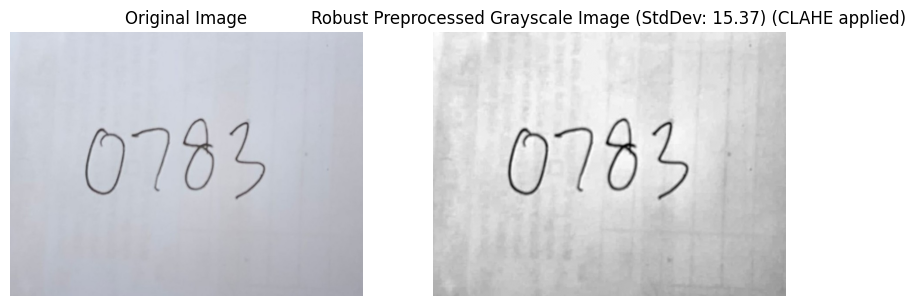

Debug visualization in segment_digits_primer_hybrid is active. Polarity:  (Polarity maintained), Path chosen: Complex Image Path (Adaptive + 2x2 Open/Erode)


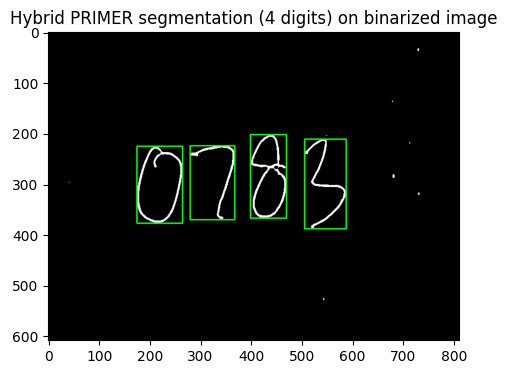

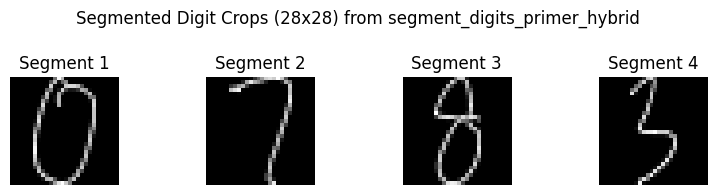

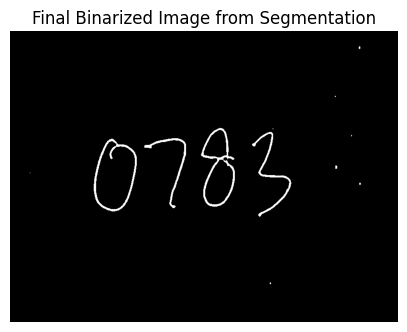

Found 4 digit candidates.


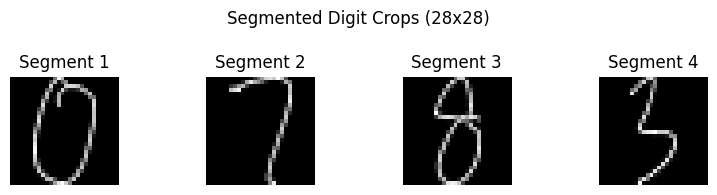

Predicted multi-digit number: 0783


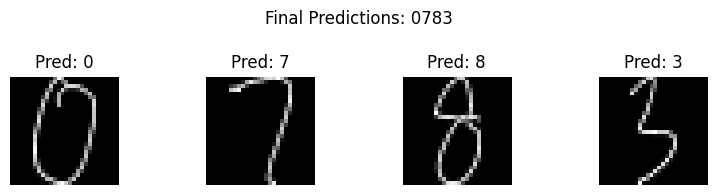

Final Prediction for test-img.jpg: 0783


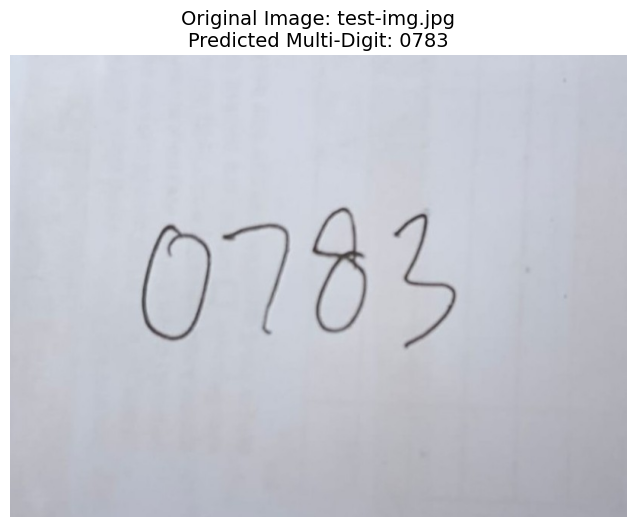

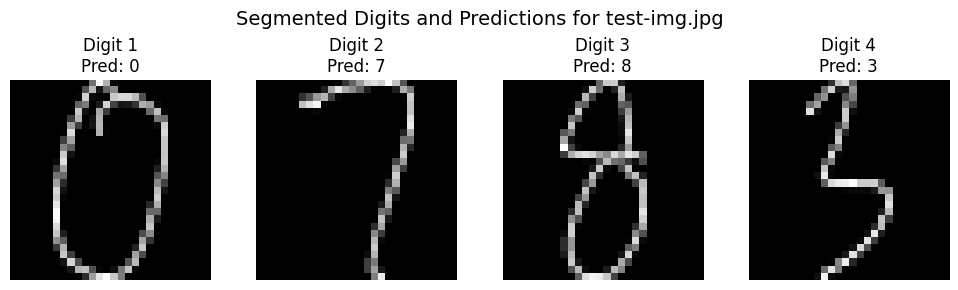

Prediction demo complete.


In [ ]:
import google.colab.files as files
import io
import cv2
import numpy as np
import matplotlib.pyplot as plt

print("Upload your multi-digit image(s) for prediction.")

# Allow user to upload files
uploaded = files.upload()

if not uploaded:
    print("No files uploaded. Skipping prediction demo.")
else:
    for fn in uploaded.keys():
        print(f'\nProcessing uploaded image: {fn}')

        # Read image data from uploaded file
        image_bytes = uploaded[fn]
        nparr = np.frombuffer(image_bytes, np.uint8)
        img_array = cv2.imdecode(nparr, cv2.IMREAD_COLOR) # Assuming color image for robust_preprocessing

        if img_array is None:
            print(f"Error: Could not decode image {fn}. Skipping.")
            continue

        # Call the prediction pipeline with debug=True for visualization
        predicted_number, segmented_digits_info = predict_multidigit_from_image(
            img_array,
            debug=True
        )

        print(f"Final Prediction for {fn}: {predicted_number}")

        if not segmented_digits_info:
            print("No digits were segmented from this image.")
            continue

        # Display original image with predicted number as title
        plt.figure(figsize=(8, 6))
        plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)) # Convert BGR to RGB for matplotlib
        plt.title(f'Original Image: {fn}\nPredicted Multi-Digit: {predicted_number}', fontsize=14)
        plt.axis('off')
        plt.show()

        # Display segmented digits with their predictions
        if segmented_digits_info:
            num_digits = len(segmented_digits_info)
            fig, axes = plt.subplots(1, num_digits, figsize=(num_digits * 2.5, 3))
            if num_digits == 1:
                axes = [axes] # Make it iterable for single digit case

            for i, digit_info in enumerate(segmented_digits_info):
                axes[i].imshow(digit_info['crop'], cmap='gray')
                axes[i].set_title(f'Digit {i+1}\nPred: {digit_info["predicted_label"]}')
                axes[i].axis('off')
            plt.suptitle(f'Segmented Digits and Predictions for {fn}', fontsize=14)
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.show()

print("Prediction demo complete.")